# イジングモデル

イジングハミルトニアンは次の式で表せる。
$$H(\{s\})=-\sum_{NN}Js_is_j-\sum_i\mu s_i$$
NNは最近接対の組みあわせを表す。

## イジングモデルの(素朴な)実装

Monte Carlo法を用い、1つずつスピンを確率的に変化させて、時間発展させる。
### 外場のないケース

ランダムな配置を準備する。上向きスピンを1、下向きスピンを-1で表す。

In [113]:
from math import exp
import numpy as np
import random
N=100
spins = np.random.randint(0,2,size=(N,N))*2-1
spins

array([[ 1, -1,  1, ...,  1,  1,  1],
       [-1,  1,  1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1,  1, -1],
       ...,
       [ 1, -1, -1, ...,  1, -1, -1],
       [-1,  1, -1, ..., -1,  1, -1],
       [ 1,  1,  1, ..., -1, -1,  1]])

温度kTを設定する。

In [114]:
kT=2.0

カップリング(相互作用)の定数Jは1とする。

In [115]:
J=1

「ここから繰り返し

マップ上の1点をランダムに選ぶ。

In [116]:
row=random.randint(0,N-1)
col=random.randint(0,N-1)
row,col

(46, 77)

その格子点のスピン値と、隣接する4点のスピン値は?

In [117]:
s0,s1,s2,s3,s4 = spins[row,col], spins[row-1,col],spins[row+1,col],spins[row,col-1],spins[row,col+1]
s0,s1,s2,s3,s4

(-1, 1, -1, -1, -1)

現在の相互作用エネルギーは、隣接するスピンの向きで決まる。

In [118]:
E0 = -J*(s0*s1 + s0*s2 + s0*s3 + s0*s4)

s0を反転させてみて、反転後のエネルギーを計算する。計算するまでもなく-E0になる

In [119]:
E1 = -E0

Metropolisの方法により、次の確率で反転を受けいれる。
1. エネルギーが低くなる場合は、確率1
2. エネルギーが高くなる場合は、確率$\exp\left({-\Delta E\over kT}\right)$


In [120]:
P = 1.0
if E1 > E0:
    dE = E1 - E0 # positive
    P = exp(-dE/kT)
if random.random() < P:
    # accept
    spins[row,col] = -spins[row,col]

ここまで繰り返し」

これでだいたいできたのだが、周期境界条件を実現するために少し工夫をする。
* rowがたまたま0の場合、spins[row-1,col]の1つ目の引数は負になるが、都合のいいことに、Pythonでは-1は最後の要素(今の場合だと99番目の要素)を指すので、自然に周期境界条件が満足される。
* rowがたまたま99の場合、spins[row+1,col]はどうなるか、というと、

In [121]:
spins[100,0]

IndexError: index 100 is out of bounds for axis 0 with size 100

エラーになってしまう。そこで、代わりにspins[row+1-100, col]を参照する。(なぜこう書くと都合がいいのでしょうか?)

全体をまとめると、

In [122]:
from math import exp
import numpy as np
import random
import time

N=100
spins = np.random.randint(0,2,size=(N,N))*2-1
kT = 2.0
J = 1.0

starttime = time.time()

for i in range(100): # 100 MC steps
    for j in range(N*N): # for every spin,
        row=random.randint(0,N-1)
        col=random.randint(0,N-1)
        s0,s1,s2,s3,s4 = spins[row,col], spins[row-1,col],spins[row+1-N,col],spins[row,col-1],spins[row,col+1-N]
        E0 = -J*(s0*s1 + s0*s2 + s0*s3 + s0*s4)
        E1 = -E0
        P = 1.0
        if E1 > E0:
            dE = E1 - E0 # positive
            P = exp(-dE/kT)
        if random.random() < P:
            # accept
            spins[row,col] = -spins[row,col]

duration = time.time() - starttime
print(duration)

11.309715986251831


spinsの内容を図にしてみる。

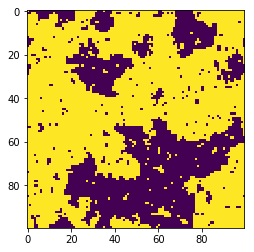

In [123]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(spins)

なんとなくドメインができているように見えるが、これが平衡状態がどうかよくわからない。そもそも、平衡に至ったかどうかを見る方法がない。

全エネルギーを計算する関数と、局所エネルギーを計算する関数をあらかじめ準備しておく。

In [126]:
def energy(spins,row,col,J=1):
    """
    Local interaction at (row, col) of spins
    """
    Nr, Nc = spins.shape
    s0,s1,s2,s3,s4 = spins[row,col], spins[row-1,col],spins[row+1-Nr,col],spins[row,col-1],spins[row,col+1-Nc]
    return -J*(s0*s1 + s0*s2 + s0*s3 + s0*s4)

def total_energy(spins,J=1):
    Nr, Nc = spins.shape
    E = 0.0
    for row in range(Nr):
        for col in range(Nc):
            E += energy(spins, row, col, J)
    return E/2

これを使って最初のエネルギーと、エネルギー変化を追跡し、最後にプロットする。

10.907204866409302


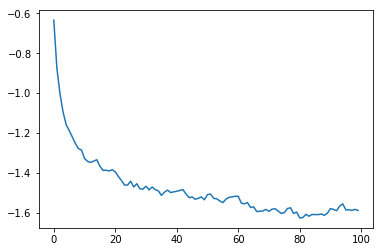

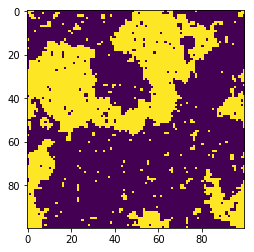

In [127]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import random
import time

N=100
spins = np.random.randint(0,2,size=(N,N))*2-1
kT = 2.0
J = 1.0

starttime = time.time()
steps = 100
E = total_energy(spins)
rec = []

for i in range(steps):
    for j in range(N*N):
        row=random.randint(0,N-1)
        col=random.randint(0,N-1)
        E0 = energy(spins,row,col)
        E1 = -E0
        dE = E1 - E0 # positive
        P = 1.0
        if E1 > E0:
            P = exp(-dE/kT)
        if random.random() < P:
            # accept
            spins[row,col] = -spins[row,col]
            E += dE
    # 1000回記録する。
    rec.append(E/(N*N))

duration = time.time() - starttime
print(duration)

plt.plot(rec)
plt.show()
plt.imshow(spins)

設定を変えて、いろいろ計算しやすいように、上のプログラム自体も関数にしてしまいます。

In [130]:
import numpy as np
import random

def ising(N, kT, J, steps):
    spins = np.random.randint(0,2,size=(N,N))*2-1

    E = total_energy(spins)
    rec = []

    for i in range(steps):
        for j in range(N*N):
            row=random.randint(0,N-1)
            col=random.randint(0,N-1)
            E0 = energy(spins,row,col)
            E1 = -E0
            dE = E1 - E0 # positive
            P = 1.0
            if E1 > E0:
                P = exp(-dE/kT)
            if random.random() < P:
                # accept
                spins[row,col] = -spins[row,col]
                E += dE
        # 1000回記録する。
        rec.append(E/(N*N))
    return rec, spins


10.305943965911865


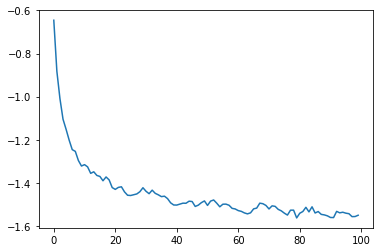

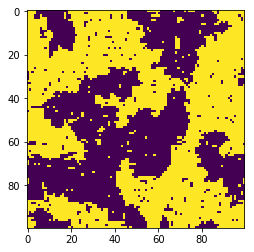

In [131]:
%matplotlib inline
from matplotlib import pyplot as plt
import time

starttime = time.time()
rec, spins = ising(N=100, kT=2.0, J=1.0, steps=100)
duration = time.time() - starttime
print(duration)
plt.plot(rec)
plt.show()
plt.imshow(spins)

イジングモデルの臨界点はkT=2.269らしいので、それより少し高温で計算して比較しましょう。

9.582489967346191


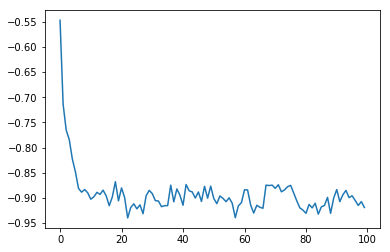

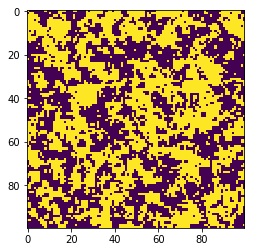

In [132]:
%matplotlib inline
from matplotlib import pyplot as plt
import time

starttime = time.time()
rec, spins = ising(N=100, kT=2.8, J=1.0, steps=100)
duration = time.time() - starttime
print(duration)
plt.plot(rec)
plt.show()
plt.imshow(spins)

温度が高いと、緩和は速く、分離が見られないことがわかります。

では臨界点を見てみましょう。

10.521330833435059


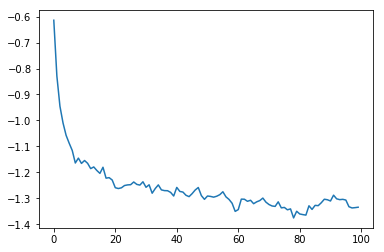

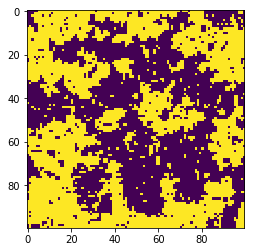

In [133]:
%matplotlib inline
from matplotlib import pyplot as plt
import time

starttime = time.time()
rec, spins = ising(N=100, kT=2.269, J=1.0, steps=100)
duration = time.time() - starttime
print(duration)
plt.plot(rec)
plt.show()
plt.imshow(spins)

分離しているように見えます。実は、臨界点をシミュレーションするには、この系のサイズでは不十分で、臨界状態を再現しているとは言えません。

### 多少速くする

エネルギーを計算する際の、`-J*(s0*s1 + s0*s2 + s0*s3 + s0*s4)`の部分は、実際にはsが$\pm 1$のいずれかしかとらず、Jも実質上1以外の数字に選ぶことはないので、(-4, -2, 0, +2, +4)の5つの値しかとりません。すると、dEの値も(-8,-4,0,4,8)の5つの値しかとらないし、温度は事前に指定されているので、$\exp(-dE/kT)$のとる値も、5つに限定されます。

これらの計算を毎回行うのは無駄なので、あらかじめ計算しておくことにしましょう。

In [134]:
import numpy as np
import random


def energy_simplified(spins,row,col):
    """
    Local interaction at (row, col) of spins
    J is always unity.
    """
    Nr, Nc = spins.shape
    s0,s1,s2,s3,s4 = spins[row,col], spins[row-1,col],spins[row+1-Nr,col],spins[row,col-1],spins[row,col+1-Nc]
    return -s0*(s1+s2+s3+s4)

def total_energy_simplified(spins):
    Nr, Nc = spins.shape
    E = 0.0
    for row in range(Nr):
        for col in range(Nc):
            E += energy(spins, row, col)
    return E/2



def ising_fast(N, kT, steps): # Jは1に固定する。
    spins = np.random.randint(0,2,size=(N,N))*2-1
    P = {-2: exp(-4.0/kT),
         -4: exp(-8.0/kT)}

    E = total_energy_simplified(spins)
    rec = []

    for i in range(steps):
        for j in range(N*N):
            row=random.randint(0,N-1)
            col=random.randint(0,N-1)
            E0 = energy_simplified(spins,row,col)
            if E0 < 0:
                if random.random() < P[E0]:
                    # accept
                    spins[row,col] = -spins[row,col]
                    E -= E0*2
            else:
                # accept
                spins[row,col] = -spins[row,col]
                E -= E0*2

        # 1000回記録する。
        rec.append(E/(N*N))
    return rec, spins



5.517317771911621


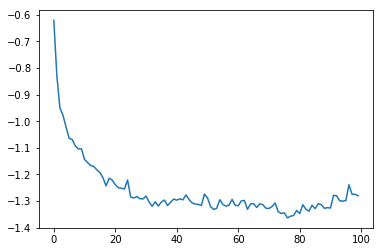

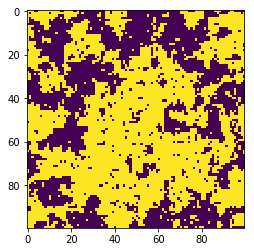

In [135]:
%matplotlib inline
from matplotlib import pyplot as plt
import time

starttime = time.time()
rec, spins = ising_fast(N=100, kT=2.269, steps=100)
duration = time.time() - starttime
print(duration)
plt.plot(rec)
plt.show()
plt.imshow(spins)

少し速くなりました。とはいえ、100 MCステップの計算に6秒もかかります。

## 爆速化

numpyのベクトル計算を利用して、どこまで速くできるかに挑戦する。

マップを、チェッカーボードのように行+列が偶数の点と奇数の点に分ける。
ある格子点のスピン反転確率は、となりの4点の状態だけで決まる。白マスにあるスピンの反転確率は、隣の4つの黒マスの状態で決まる。
ある白マスのスピンを反転しても、隣の白マスには全く影響が及ばないので、白マスはすべて同時に反転試行しても構わない、ということになる。


kT=2.1, 64.0920958518982 sec.


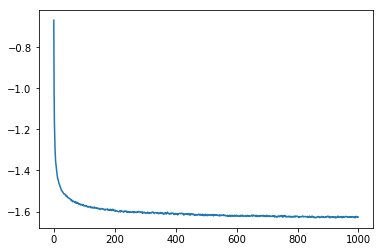

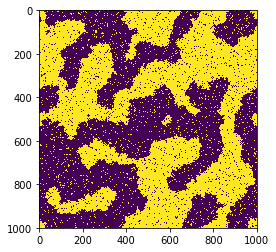

kT=2.2, 71.63781905174255 sec.


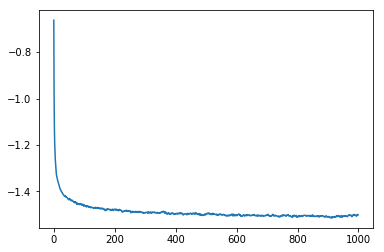

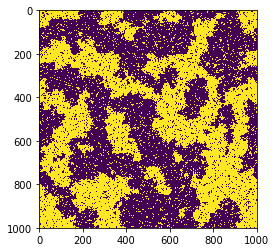

kT=2.3, 70.39711427688599 sec.


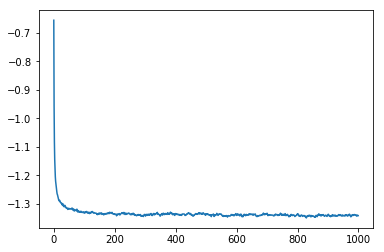

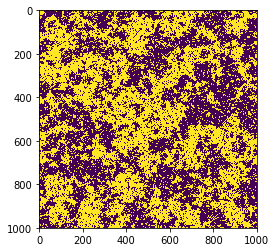

kT=2.4, 70.6879448890686 sec.


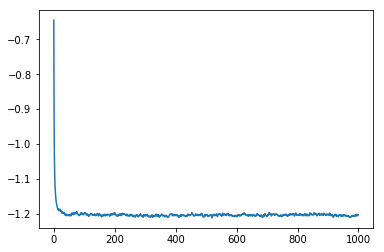

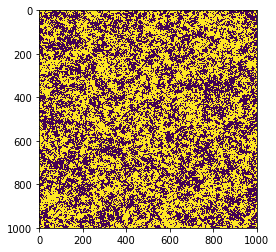

In [136]:
%matplotlib inline
from matplotlib import pyplot as plt
import time
from math import exp
import numpy as np


def ising_fastest(N, kT, J, steps):
    spins = np.random.randint(0,2,size=(N,N))*2-1
    # make a checker board
    colmap = np.array([np.arange(N) for i in range(N)])
    rowmap = colmap.T
    checker = (colmap+rowmap) % 2 == 0
    inverted = checker == False
    #print(checker)
    #print(inverted)

    P = np.array([min(exp(J*i/kT),1) for i in range(-8,9)])
    #print(P)
    rec = []
    for loop in range(steps):
        for parity in (checker, inverted): #2部に分けて更新する。(半分の計算はただ捨てる)
            neighbors = np.roll(spins,1,axis=0) + np.roll(spins,-1,axis=0) + np.roll(spins,1,axis=1) + np.roll(spins,-1,axis=1)
            interactions=spins*neighbors
            # print(-J*np.sum(interactions)/N**2, np.sum(grid)/N**2)
            dSS=-interactions*2
            # print(dSS)
            probs=P[dSS+8]
            accept=probs>np.random.random((N,N))
            # print(accept)
            lastspins = spins.copy()
            spins[accept&parity] = -spins[accept&parity]
            #plt.imshow(spins-lastspins)
            #plt.show()
        rec.append(np.sum(-J*interactions)/2/(N*N))
    return rec, spins

for kT in (2.1, 2.2, 2.3, 2.4):
    starttime = time.time()
    rec, spins = ising_fastest(N=1000, kT=kT, J=1.0, steps=1000)
    duration = time.time() - starttime
    print("kT={0}, {1} sec.".format(kT, duration))
    plt.plot(rec)
    plt.show()
    plt.imshow(spins)
    plt.show()


だいたい100倍速くなった。1000x1000のマップで、1000ステップぐらい計算すると、kT=2.2〜2.3で結果が変化するのがわかる。臨界点近くでは、1000 MC stepsでは不十分なようだ。

## 外場がある場合

格子ガスのシミュレーション(一次相転移)のためには、外場を印加する必要がある。

## もっと速く!

もっと速くするには、コアの部分をFortranなどで書くのが良いでしょう。f2pyを使うと、ほとんど障壁なく